In [1]:
import awkward
import xgboost
import numpy as np
import os
import json
import awkward as ak
import coffea.util as util
#%pip install sklearn
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

import hist

In [2]:
xgboost.__version__

'2.0.3'

In [3]:
proc_dict = {
    "ggh_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/ggh_M125_2017/NOTAG_merged.parquet",
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_signal_2017_newBDT/merged/ggh_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 1,
    },
    "tth_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/tth_M125_2017/NOTAG_merged.parquet",
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_signal_2017_newBDT/merged/tth_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 2,
    },
    "vbf_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/vbf_M125_2017/NOTAG_merged.parquet",
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_signal_2017_newBDT/merged/vbf_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 3,
    },
    "vh_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/vh_M125_2017/NOTAG_merged.parquet",
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_signal_2017_newBDT/merged/vh_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 4,
    },
    "cH_4FS_FXFX_M125_2017": {
        # "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/cH_4FS_FXFX_M125_2017/NOTAG_merged.parquet",
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_signal_2017_newBDT/merged/cH_4FS_FXFX_M125_2017/NOTAG_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 5,
    },
    # "bH_5FS_FXFX_M125_2017": {
    #     "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/bH_5FS_FXFX_M125_2017/nominal/NOTAG_merged.parquet",
    #     "type": "background",
    #     "label": 0.,
    #     "proc_id": 6,
    # }
}

In [4]:
e = ak.from_parquet("/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_signal_2017_newBDT/merged/ggh_M125_2017/NOTAG_merged.parquet")

with open(
        "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master2/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/cross_sections.json", "r"
    ) as pf:
        XSs = json.load(pf)

In [5]:
sig_events = []
bkg_events = []
data_events = []


columns = [f for f in e.fields]
               
for i, dataset in enumerate(proc_dict):
    if "Data" not in dataset:
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        print(f"{dataset}: xsec = {XSs[dataset]['xs']}, bf = {XSs[dataset]['bf']}, lumi = {XSs['lumi']['2017']}, norm = {norm}")
    else:
        print(f"{dataset}")
    if proc_dict[dataset]["type"] == "signal":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(sig_events) == 0:
            sig_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            sig_events["weight"] = sig_events["weight"] * norm
            sig_events["proc_id"] = ak.ones_like(sig_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            sig_events = ak.concatenate([sig_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        print(f'|----> number of events: {len(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
    
    elif proc_dict[dataset]["type"] == "background":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(bkg_events) == 0:
            bkg_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            bkg_events["weight"] = bkg_events["weight"] * norm
            bkg_events["proc_id"] = ak.ones_like(bkg_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm if (proc_dict[dataset]["proc_id"] != -2 and proc_dict[dataset]["proc_id"] != -3) else tmp_["weight"] * norm * 1.52
            #tmp_["weight"] = tmp_["weight"] * norm * 1.42
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            bkg_events = ak.concatenate([bkg_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(bkg_events[bkg_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        print(f'|----> number of events: {len(bkg_events[bkg_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        
    elif proc_dict[dataset]["type"] == "data":
        if len(data_events) == 0:
            data_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            data_events["proc_id"] = ak.ones_like(data_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            data_events = ak.concatenate([data_events, tmp_])

sig_events["label"] = ak.ones_like(sig_events["weight"])
bkg_events["label"] = ak.zeros_like(bkg_events["weight"])
# data_events["label"] = ak.ones_like(data_events["weight"]) * -1. 

ggh_M125_2017: xsec = 48.58, bf = 0.00227, lumi = 41.5, norm = 4576.4789
|----> sum normalised weights: 1107.0507859017773
|----> number of events: 262972
tth_M125_2017: xsec = 0.5071, bf = 0.00227, lumi = 41.5, norm = 47.77135549999999
|----> sum normalised weights: 22.699130614874377
|----> number of events: 384537
vbf_M125_2017: xsec = 3.782, bf = 0.00227, lumi = 41.5, norm = 356.28331
|----> sum normalised weights: 124.35722079991407
|----> number of events: 1490640
vh_M125_2017: xsec = 2.2555, bf = 0.00227, lumi = 41.5, norm = 212.47937749999997
|----> sum normalised weights: 73.27163144908486
|----> number of events: 330893
cH_4FS_FXFX_M125_2017: xsec = 0.09013, bf = 0.00227, lumi = 41.5, norm = 8.490696649999999
|----> sum normalised weights: 1.9303478932234095
|----> number of events: 1281864


In [6]:
MC_events = ak.concatenate([sig_events, bkg_events[bkg_events.proc_id > -80]])

# add VtxProbability 
MC_events["vtxProb"] = 2 * MC_events["sigmaMrv"] / (MC_events["sigmaMrv"] + MC_events["sigmaMwv"])
# data_events["vtxProb"] = 2 * data_events["sigmaMrv"] / (data_events["sigmaMrv"] + data_events["sigmaMwv"])
MC_events = ak.values_astype(MC_events, np.float64)
data_events = ak.values_astype(data_events, np.float64)

MC_events["dEta_ljh"] = abs(MC_events.eta - MC_events.first_jet_eta)
MC_events["dEta_sljh"] = abs(MC_events.eta - MC_events.second_jet_eta)
MC_events["dR_ljlp"] = np.sqrt((MC_events.LeadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma1_cjet)**2)
MC_events["dR_ljslp"] = np.sqrt((MC_events.SubleadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma2_cjet)**2)

MC_events["lj_ptoM"] = abs(MC_events.first_jet_pt/MC_events.first_jet_mass)
MC_events["slj_ptoM"] = abs(MC_events.second_jet_pt/MC_events.second_jet_mass)

MC_events["first_SV_ptoM"] = MC_events.first_sv_pt/MC_events.first_sv_mass
MC_events["first_SV_ptoH_pt"] = MC_events.first_sv_pt/MC_events.pt
MC_events["Sv_J_MoM"] = abs(MC_events.first_sv_mass/MC_events.first_jet_mass)

MC_events["second_SV_ptoM"] = MC_events.second_sv_pt/MC_events.second_sv_mass

In [7]:
MC_events["dEta_ljh"] = abs(MC_events.eta - MC_events.first_jet_eta)
MC_events["dEta_sljh"] = ak.where(
    MC_events["second_jet_eta"] != -999.,
    abs(MC_events.eta - MC_events.second_jet_eta),
    ak.ones_like(MC_events.second_jet_eta) * -1
)
MC_events["dR_ljlp"] = np.sqrt((MC_events.LeadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma1_cjet)**2)
MC_events["dR_ljslp"] = np.sqrt((MC_events.SubleadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma2_cjet)**2)

MC_events["lj_ptoM"] = abs(MC_events.first_jet_pt/MC_events.first_jet_mass)
MC_events["slj_ptoM"] = MC_events.second_jet_pt/MC_events.second_jet_mass

MC_events["first_SV_ptoM"] = ak.where(
    MC_events.first_sv_pt != -999,
    MC_events.first_sv_pt/MC_events.first_sv_mass,
    ak.ones_like(MC_events.first_sv_pt) * -1
)
MC_events["first_SV_ptoH_pt"] = MC_events.first_sv_pt/MC_events.pt
MC_events["Sv_J_MoM"] = ak.where(
    MC_events.first_sv_pt != -999,
    abs(MC_events.first_sv_mass/MC_events.first_jet_mass),
    ak.ones_like(MC_events.first_sv_pt) * -1
)

/work/bevila_t/MINICONDA3/envs/higgs-dna/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


In [8]:
MC_events["Sv_J_MoM"] = awkward.where(
        MC_events["Sv_J_MoM"] > 50000,
        ak.ones_like(MC_events.Sv_J_MoM) * 50000,
        MC_events["Sv_J_MoM"]
)
MC_events["lj_ptoM"] = awkward.where(
        MC_events["lj_ptoM"] > 50000,
        ak.ones_like(MC_events.lj_ptoM) * 50000,
        MC_events["lj_ptoM"]
)
MC_events["slj_ptoM"] = awkward.where(
        MC_events["slj_ptoM"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["slj_ptoM"]
)
MC_events["lj_ptoM"] = awkward.where(
        MC_events["lj_ptoM"] < -1.,
        ak.ones_like(MC_events.lj_ptoM) * -1,
        MC_events["lj_ptoM"]
)
MC_events["slj_ptoM"] = awkward.where(
        MC_events["slj_ptoM"] < -1.,
        ak.ones_like(MC_events.slj_ptoM) * -1,
        MC_events["slj_ptoM"]
)
MC_events["first_SV_ptoM"] = awkward.where(
        MC_events["first_sv_pt"] < -1.,
        ak.ones_like(MC_events.slj_ptoM) * -1.,
        MC_events["first_SV_ptoM"]
)
MC_events["first_sv_mass"] = awkward.where(
        MC_events["first_sv_mass"] < -1,
        ak.ones_like(MC_events.slj_ptoM) * -1.,
        MC_events["first_sv_mass"]
)
MC_events["first_sv_pt"] = awkward.where(
        MC_events["first_sv_pt"] < -1,
        ak.ones_like(MC_events.first_sv_pt) * -1.,
        MC_events["first_sv_pt"]
)
MC_events["first_jet_n_sv"] = awkward.where(
        MC_events["first_jet_n_sv"] < -10,
        ak.ones_like(MC_events.first_jet_n_sv) * -1.,
        MC_events["first_jet_n_sv"]
)
MC_events["first_jet_n_muons"] = awkward.where(
        MC_events["first_jet_n_muons"] < -10,
        ak.ones_like(MC_events.first_jet_n_muons) * -1.,
        MC_events["first_jet_n_muons"]
)
MC_events["first_jet_n_electrons"] = awkward.where(
        MC_events["first_jet_n_electrons"] < -10,
        ak.ones_like(MC_events.first_jet_n_electrons) * -1.,
        MC_events["first_jet_n_electrons"]
)
MC_events["first_SV_ptoH_pt"] = awkward.where(
        MC_events["first_SV_ptoH_pt"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["first_SV_ptoH_pt"]
)
MC_events["first_SV_ptoH_pt"] = awkward.where(
        MC_events["first_SV_ptoH_pt"] < 0,
        ak.ones_like(MC_events.slj_ptoM) * -1,
        MC_events["first_SV_ptoH_pt"]
)

In [9]:
MC_events.first_sv_mass

<Array [-1, -1, 1.19, 0.705, ... 1.8, -1, 0.35] type='3750906 * ?float64'>

In [10]:
models = {
    "full_TaggerInfo": {
        "config": "inputs/cH_vs_ggH_bdt_config_TaggerInfo.json",
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights041624_full_transform_nosign_tagger",
        "bdt": []
    }, 
    "full_TaggerInfo_double_ggH": {
        "config": "inputs/cH_vs_ggH_bdt_config_TaggerInfo.json",
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights041624_full_transform_nosign_boostggh_tagger",
        "bdt": []
    }, 
    "full": {
        "config": "inputs/cH_vs_ggH_bdt_config.json",
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights042524_full_transform_nosign",
        "bdt": []
    },
    "full_double_ggH": {
        "config": "inputs/cH_vs_ggH_bdt_config.json",
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights041624_full_transform_nosign_boostggh",
        "bdt": []
    },
    "ggh_only": {
        "config": "inputs/cH_vs_ggH_bdt_config.json",
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights041824_gghonly_transform_nosign",
        "bdt": []
    },
    "ggh_only_TaggerInfo": {
        "config": "inputs/cH_vs_ggH_bdt_config_TaggerInfo.json",
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/XGBoost_models/optimised/weights041624_gghonly_transform_nosign_tagger",
        "bdt": []
    },
}

for model in [*models]:
    bdt = []
    for i, set in enumerate(["even", "odd"]):
        tmp_boost = xgboost.Booster()
        tmp_boost.load_model(f"{models[model]['file']}_{set}.xgb")
        bdt.append(tmp_boost)
    models[model]["bdt"] = bdt

In [11]:
config = models["full_TaggerInfo_double_ggH"]["config"]
with open(config, "r") as f_in:
    bdt_config = json.load(f_in)
    
for field in bdt_config["features"]:
    if field != "n_jets":
        print(field, MC_events[field])
        MC_events[field] = MC_events[field] / bdt_config["features_norm"][field]
        # features[field] = features[field] * np.sign(features[field])
        print(field, MC_events[field])

LeadPhoton_pt_mgg [0.577, 0.623, 0.891, 0.583, 0.561, 0.502, ... 0.5, 0.614, 0.813, 0.853, 0.819]
LeadPhoton_pt_mgg [0.0289, 0.0312, 0.0445, 0.0292, 0.0281, ... 0.025, 0.0307, 0.0406, 0.0426, 0.0409]
SubleadPhoton_pt_mgg [0.352, 0.465, 0.388, 0.32, 0.45, 0.451, ... 0.304, 0.433, 0.52, 0.513, 0.334, 0.805]
SubleadPhoton_pt_mgg [0.0587, 0.0775, 0.0646, 0.0533, 0.075, ... 0.0722, 0.0866, 0.0855, 0.0557, 0.134]
Diphoton_cos_dPhi [-0.436, -0.723, -0.436, -0.941, -0.827, ... -0.915, -0.568, -0.141, -0.737, 0.29]
Diphoton_cos_dPhi [-0.436, -0.723, -0.436, -0.941, -0.827, ... -0.915, -0.568, -0.141, -0.737, 0.29]
LeadPhoton_eta [0.449, 0.504, 1.35, 1.4, -1.71, -1.42, ... -1.83, -0.591, 0.773, 0.458, -0.694]
LeadPhoton_eta [0.179, 0.202, 0.54, 0.56, -0.683, -0.568, ... -0.731, -0.236, 0.309, 0.183, -0.278]
SubleadPhoton_eta [-0.885, 0.473, 1.22, 0.247, -2.26, -0.602, ... -0.975, -0.668, 0.398, 0.666, -0.384]
SubleadPhoton_eta [-0.354, 0.189, 0.488, 0.0989, -0.902, ... -0.39, -0.267, 0.159, 0.26

In [12]:
for model in [*models]:
    config = models[model]["config"]

    with open(config, "r") as f_in:
        bdt_config = json.load(f_in)

    features = MC_events[bdt_config["features"]]
    print(model)
    #for field in bdt_config["features"]:
    #        if field != "n_jets":
    #            print(field, features[field])
    #            features[field] = features[field] / max(features[field])
    #            # features[field] = features[field] * np.sign(features[field])
    #            print(field, features[field])
    features = awkward.to_numpy(features)
    features = features.view((float, len(features.dtype.names)))
    dmat_eval = xgboost.DMatrix(
        features,
        awkward.to_numpy(MC_events["label"])
    )
    bdt_score_0 = models[model]["bdt"][1].predict(dmat_eval) # xgboost.DMatrix(features))
    bdt_score_1 = models[model]["bdt"][0].predict(dmat_eval) # xgboost.DMatrix(features))

    MC_events[f"mva_score_{model}"] = ak.where(
        MC_events.event % 2 == 0,
        bdt_score_0,
        bdt_score_1
    )

full_TaggerInfo
full_TaggerInfo_double_ggH
full
full_double_ggH
ggh_only
ggh_only_TaggerInfo


In [13]:
MC_events["square_weight"] = MC_events.weight ** 2

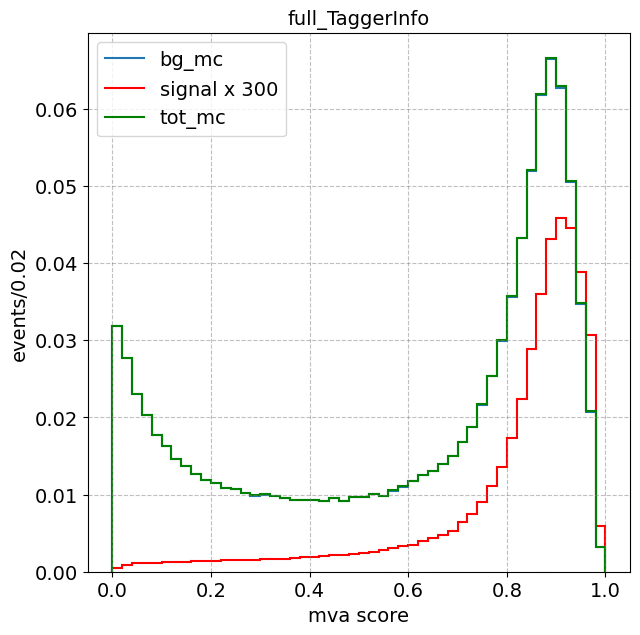

<Figure size 640x480 with 0 Axes>

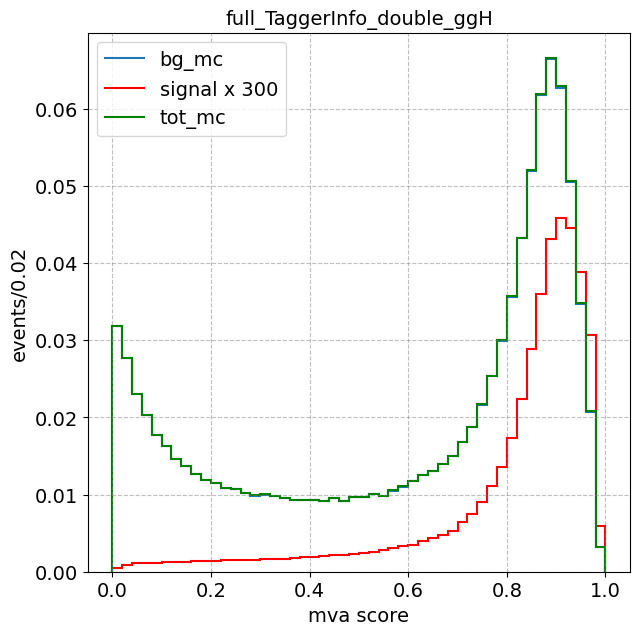

<Figure size 640x480 with 0 Axes>

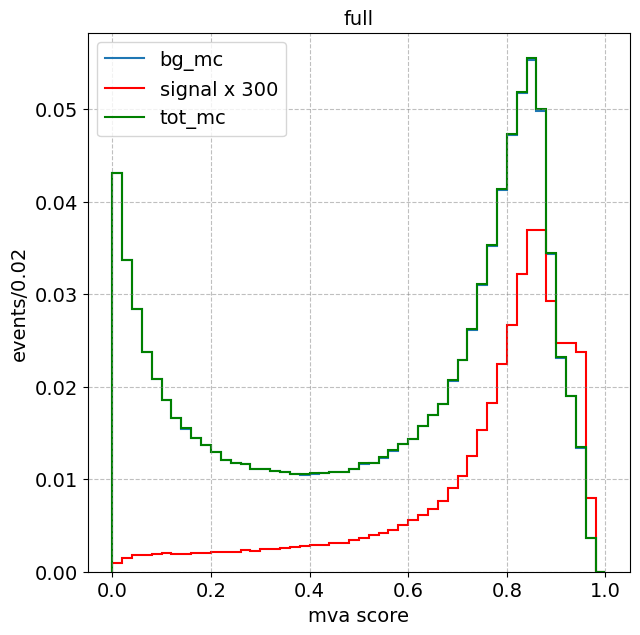

<Figure size 640x480 with 0 Axes>

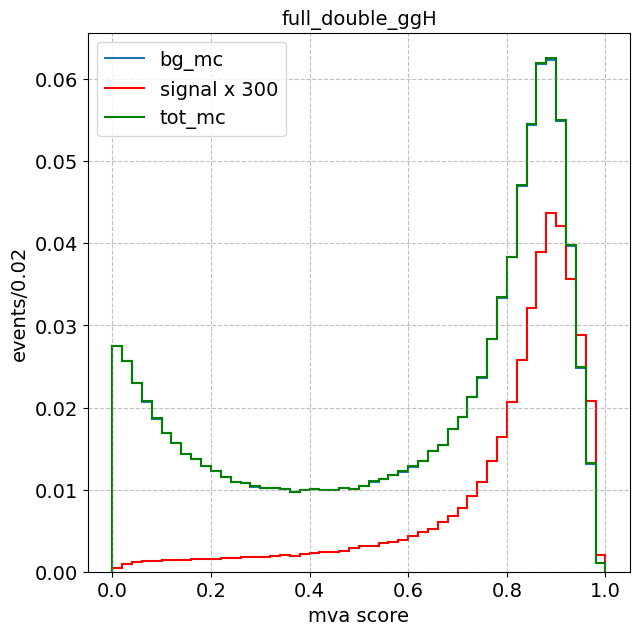

<Figure size 640x480 with 0 Axes>

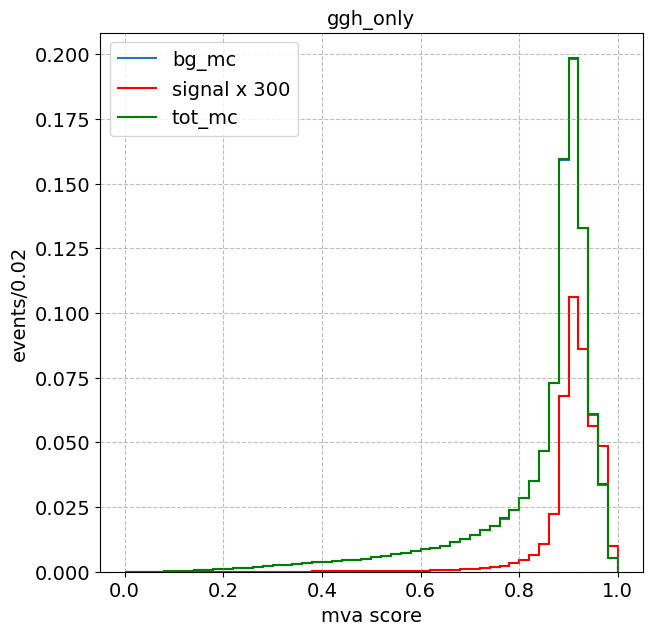

<Figure size 640x480 with 0 Axes>

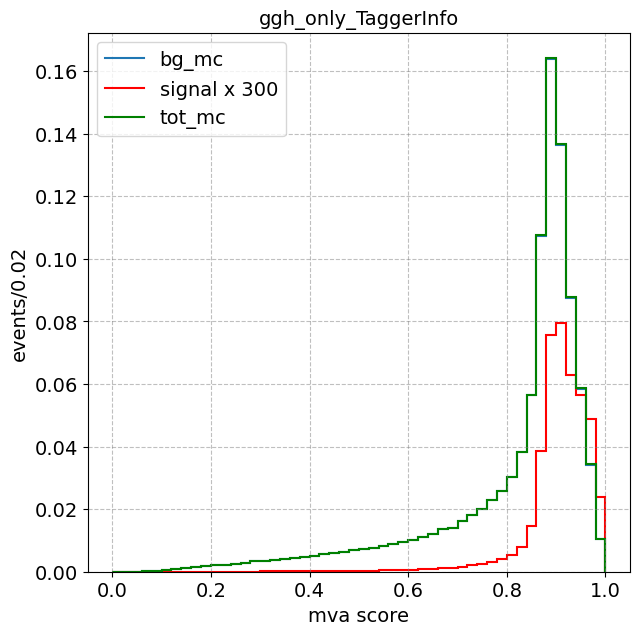

<Figure size 640x480 with 0 Axes>

In [14]:
#bdt_score
for model in [*models]:
    fig, axs = plt.subplots(1,1, figsize=(7, 7))
    min_ = 0
    max_ = 1
    nbins = 50
    h_bdt_score_tot = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_tot_err = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_sig = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_bg = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_tot.fill(bdt_score_tot = MC_events[f'mva_score_{model}'], weight = MC_events.weight/ak.sum(MC_events.weight))
    h_bdt_score_tot_err.fill(bdt_score_tot = MC_events[f'mva_score_{model}'], weight = MC_events.square_weight)
    h_bdt_score_sig.fill(bdt_score_tot = MC_events[f'mva_score_{model}'][(MC_events.label == 1)], weight = MC_events.weight[(MC_events.label == 1)]/ak.sum(MC_events.weight))
    h_bdt_score_bg.fill( bdt_score_tot = MC_events[f'mva_score_{model}'][(MC_events.label == 0)], weight = MC_events.weight[(MC_events.label == 0)]/ak.sum(MC_events.weight))
    
    h_bdt_score_sig = h_bdt_score_sig * 300 

    h_bdt_score_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
    h_bdt_score_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 300")
    h_bdt_score_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")

    axs.legend( prop={'size': 14})
    axs.grid(color='grey', linestyle='--', alpha=0.5)
    axs.set_ylabel('events')
    # axs.set_yscale('log')
    axs.set_xlabel('mva score', fontsize=14)
    axs.set_ylabel('events/0.02', fontsize=14)
    axs.set_title(model, fontsize=14)
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)

    plt.plot()
    plt.show()
    plt.savefig("plots/mva_score_sig_bg.pdf")

In [15]:
weight = "weight"

In [16]:
sig_fpr = {}
sig_tpr = {}
frac_sob = {}
cuts = {}
MC_events["weight_train"] = ak.ones_like(MC_events.weight)

for model in [*models]:
    sig_fpr[model] = []
    sig_tpr[model] = []
    frac_sob[model] = []
    cuts[model] = []
    print(f"processing model: {model}")
    for i in range(80):
        step = 1/80.
        cuts[model].append(i * step)
        ch = MC_events[MC_events.proc_id == 5]
        ggh = MC_events[MC_events.proc_id == 1]
        if i == 0:
            print(f'tot events = {len(ch)+len(ggh)}, signal event number = {len(ch)}, ggh event number = {len(ggh)}')

        sum_sig = ak.sum(ch[weight])
        sum_bkg = ak.sum(ggh[weight])
        pass_sig = ak.sum(ch[weight][ch[f"mva_score_{model}"] > i * step])
        pass_bkg = ak.sum(ggh[weight][ggh[f"mva_score_{model}"] > i * step])

        #print(f"|----> signal: {signal}")
        #print(f"|--------> passing fraction first_jet_DeepFlavour_CvsL = {pass_deepjet_sig/sum_sig:.3f}")
        #print(f"|--------> passing fraction first_jet_particleNetAK4_CvsL = {pass_pnet_sig/sum_sig:.3f}")
        sig_tpr[model].append(pass_sig/sum_sig)
        #print(f"|----> background: {signal}")
        #print(f"|----> passing fraction first_jet_DeepFlavour_CvsL = {pass_deepjet_bkg/sum_bkg:.3f}")
        # print(f"|----> passing fraction first_jet_particleNetAK4_CvsL = {pass_pnet_bkg/sum_bkg:.3f}")
        sig_fpr[model].append(pass_bkg/sum_bkg)
        # print(f"|----> sig/bkg")
        # print(f"|----> passing fraction first_jet_DeepFlavour_CvsL = {(pass_deepjet_sig/sum_sig)/(pass_deepjet_bkg/sum_bkg):.3f}")
        # print(f"|----> passing fraction first_jet_particleNetAK4_CvsL = {(pass_pnet_sig/sum_sig)/(pass_pnet_bkg/sum_bkg):.3f}")
        frac_sob[model].append((pass_sig/sum_sig)/(pass_bkg/sum_bkg))

processing model: full_TaggerInfo
tot events = 1544836, signal event number = 1281864, ggh event number = 262972


processing model: full_TaggerInfo_double_ggH
tot events = 1544836, signal event number = 1281864, ggh event number = 262972
processing model: full
tot events = 1544836, signal event number = 1281864, ggh event number = 262972


/tmp/ipykernel_63369/1778990432.py:37: RuntimeWarning: invalid value encountered in double_scalars
  frac_sob[model].append((pass_sig/sum_sig)/(pass_bkg/sum_bkg))


processing model: full_double_ggH
tot events = 1544836, signal event number = 1281864, ggh event number = 262972
processing model: ggh_only
tot events = 1544836, signal event number = 1281864, ggh event number = 262972
processing model: ggh_only_TaggerInfo
tot events = 1544836, signal event number = 1281864, ggh event number = 262972


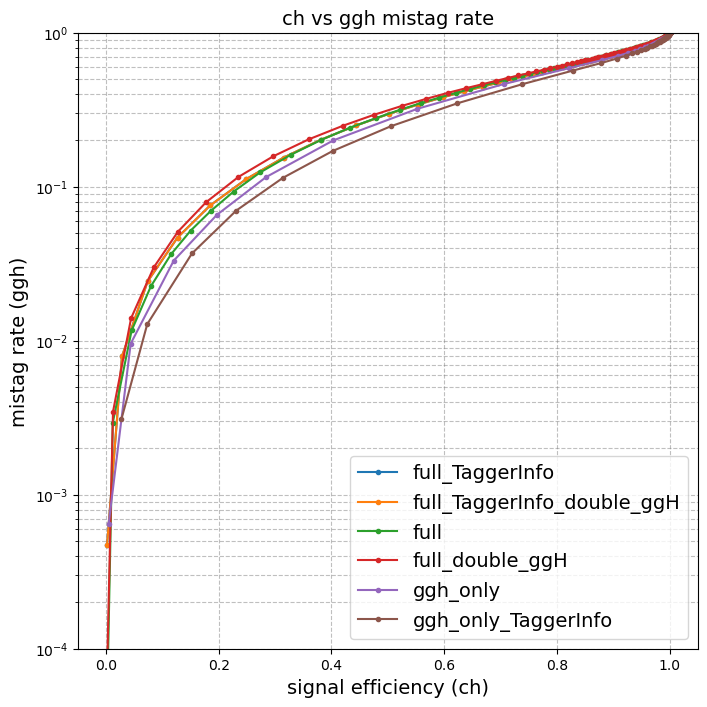

In [17]:
fig = plt.figure(figsize=(8, 8))
plt.title(f"ch vs ggh mistag rate", fontsize=14)
for model in [*models]:
    plt.plot(sig_tpr[model], sig_fpr[model], marker='.', label=model)
plt.legend(fontsize=14)
plt.ylabel("mistag rate (ggh)", fontsize=14)
plt.xlabel("signal efficiency (ch)", fontsize=14)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.grid(color='grey', linestyle='--', alpha=0.5, which='both')

In [18]:
sig_fpr = {}
sig_tpr = {}
frac_sob = {}
cuts = {}
MC_events["weight_train"] = ak.ones_like(MC_events.weight)
for model in [*models]:
    sig_fpr[model] = []
    sig_tpr[model] = []
    frac_sob[model] = []
    cuts[model] = []
    print(f"processing model: {model}")
    for i in range(80):
        step = 1/80.
        cuts[model].append(i * step)
        ch = MC_events[MC_events.proc_id == 5]
        bkg = MC_events[MC_events.proc_id != 5]
        if i == 0:
            print(f'tot events = {len(ch)+len(bkg)}, signal event number = {len(ch)}, ggh event number = {len(bkg)}')

        sum_sig = ak.sum(ch[weight])
        sum_bkg = ak.sum(bkg[weight])
        pass_sig = ak.sum(ch[weight][ch[f"mva_score_{model}"] > i * step])
        pass_bkg = ak.sum(bkg[weight][bkg[f"mva_score_{model}"] > i * step])

        #print(f"|----> signal: {signal}")
        #print(f"|--------> passing fraction first_jet_DeepFlavour_CvsL = {pass_deepjet_sig/sum_sig:.3f}")
        #print(f"|--------> passing fraction first_jet_particleNetAK4_CvsL = {pass_pnet_sig/sum_sig:.3f}")
        sig_tpr[model].append(pass_sig/sum_sig)
        #print(f"|----> background: {signal}")
        #print(f"|----> passing fraction first_jet_DeepFlavour_CvsL = {pass_deepjet_bkg/sum_bkg:.3f}")
        # print(f"|----> passing fraction first_jet_particleNetAK4_CvsL = {pass_pnet_bkg/sum_bkg:.3f}")
        sig_fpr[model].append(pass_bkg/sum_bkg)
        # print(f"|----> sig/bkg")
        # print(f"|----> passing fraction first_jet_DeepFlavour_CvsL = {(pass_deepjet_sig/sum_sig)/(pass_deepjet_bkg/sum_bkg):.3f}")
        # print(f"|----> passing fraction first_jet_particleNetAK4_CvsL = {(pass_pnet_sig/sum_sig)/(pass_pnet_bkg/sum_bkg):.3f}")
        frac_sob[model].append((pass_sig/sum_sig)/(pass_bkg/sum_bkg))

processing model: full_TaggerInfo
tot events = 3750906, signal event number = 1281864, ggh event number = 2469042
processing model: full_TaggerInfo_double_ggH
tot events = 3750906, signal event number = 1281864, ggh event number = 2469042
processing model: full
tot events = 3750906, signal event number = 1281864, ggh event number = 2469042


/tmp/ipykernel_63369/1562496928.py:36: RuntimeWarning: invalid value encountered in double_scalars
  frac_sob[model].append((pass_sig/sum_sig)/(pass_bkg/sum_bkg))


processing model: full_double_ggH
tot events = 3750906, signal event number = 1281864, ggh event number = 2469042
processing model: ggh_only
tot events = 3750906, signal event number = 1281864, ggh event number = 2469042
processing model: ggh_only_TaggerInfo
tot events = 3750906, signal event number = 1281864, ggh event number = 2469042


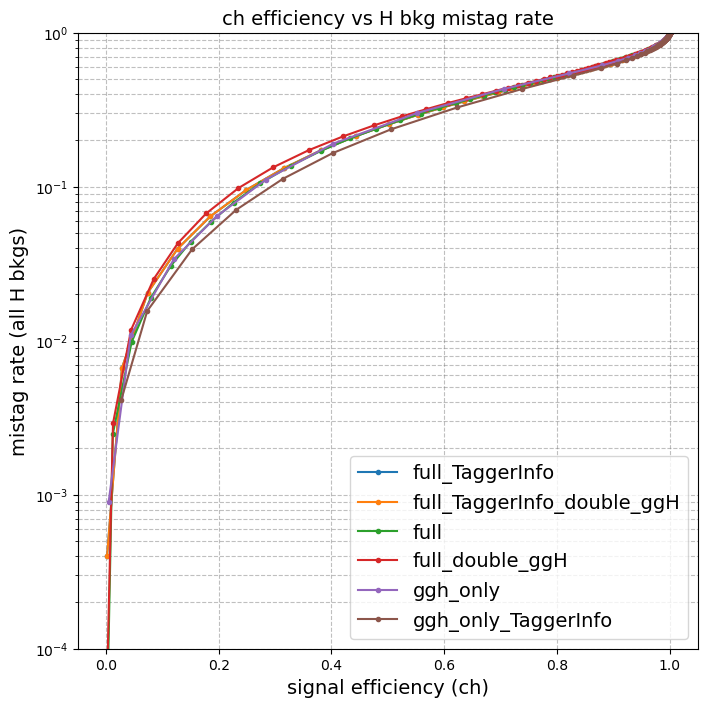

In [19]:
fig = plt.figure(figsize=(8, 8))
plt.title(f"ch efficiency vs H bkg mistag rate", fontsize=14)
for model in [*models]:
    plt.plot(sig_tpr[model], sig_fpr[model], marker='.', label=model)
plt.legend(fontsize=14)
plt.ylabel("mistag rate (all H bkgs)", fontsize=14)
plt.xlabel("signal efficiency (ch)", fontsize=14)
plt.yscale("log")
plt.ylim(1e-4,1)
plt.grid(color='grey', linestyle='--', alpha=0.5, which='both')

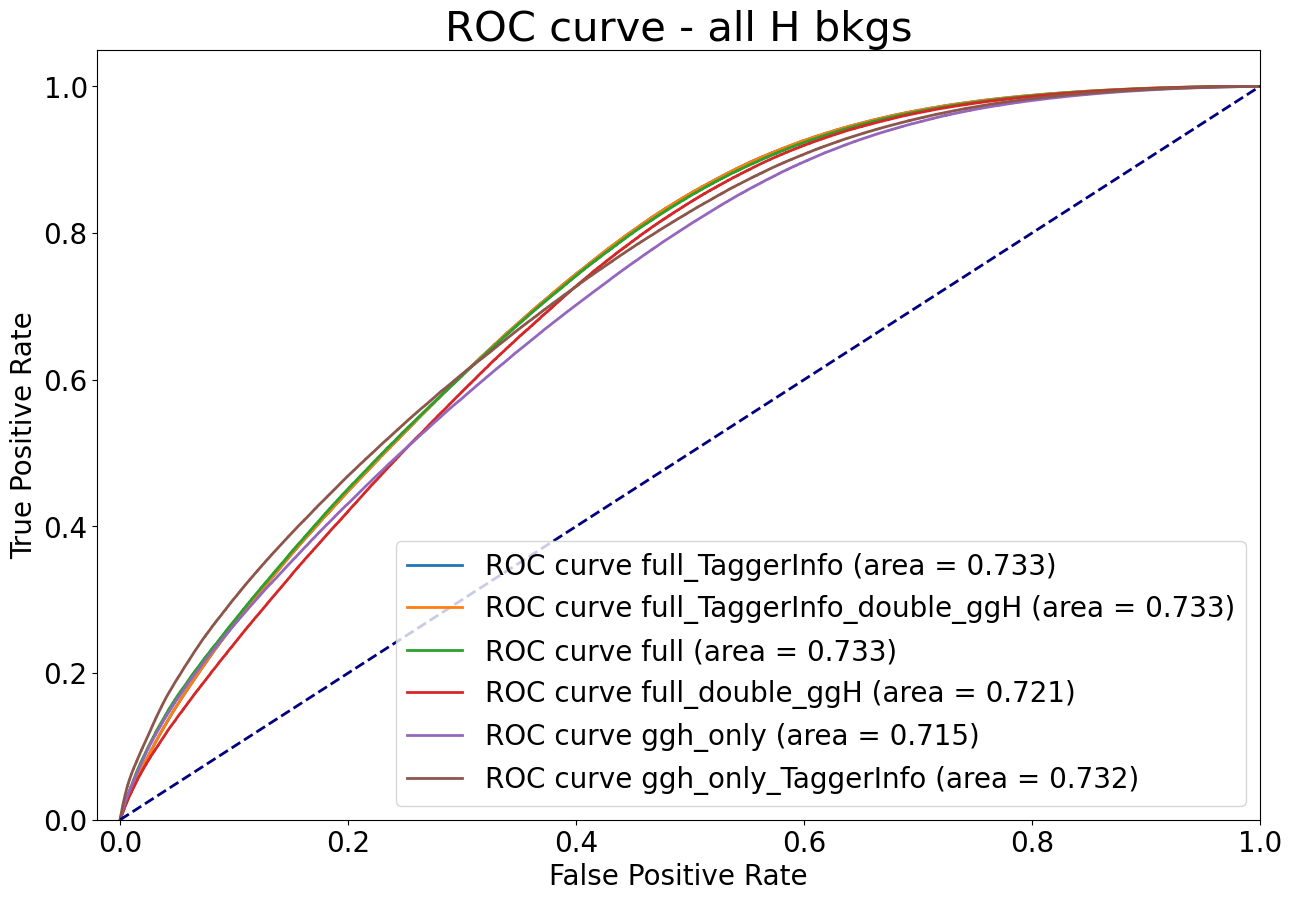

In [20]:
# Compute micro-average ROC curve and ROC area
# for i, MC in enumerate([MC_events[(MC_events.proc_id == 1) | (MC_events.proc_id == 5)]]): 
fig = plt.figure(figsize=(15,10))
lw = 2
for model in [*models]:
    fpr, tpr, _ = roc_curve(MC_events["label"], MC_events[f"mva_score_{model}"], sample_weight=abs(MC_events[weight]))
    sample_weight=abs(MC_events[weight])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve %s (area = %0.3f)' % (model, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC curve - all H bkgs', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

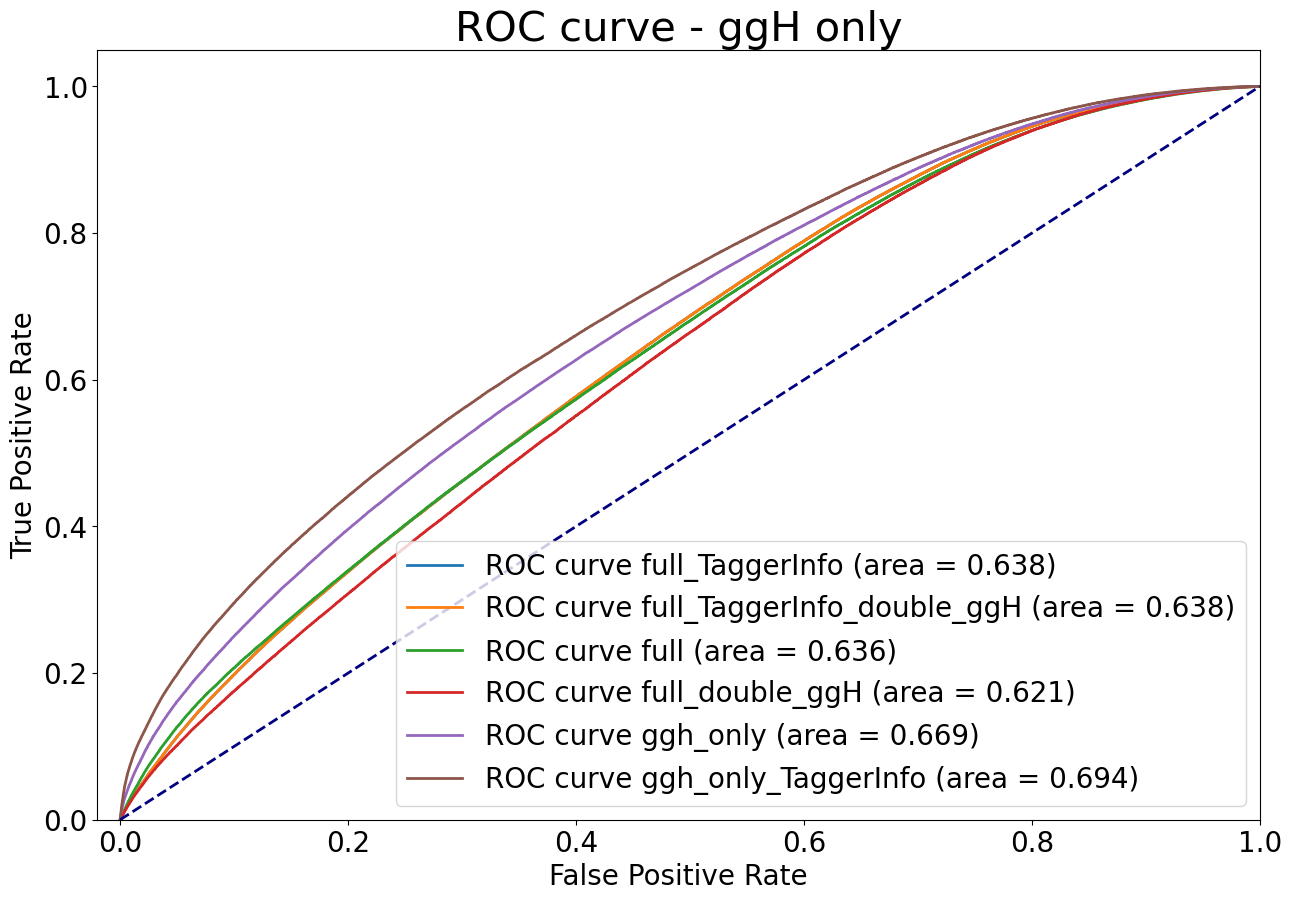

In [21]:
fig = plt.figure(figsize=(15,10))
lw = 2
for model in [*models]:
    MC = MC_events[(MC_events.proc_id == 1) | (MC_events.proc_id == 5)]
    fpr, tpr, _ = roc_curve(MC["label"], MC[f"mva_score_{model}"], sample_weight=abs(MC[weight]))
    sample_weight=abs(MC[weight])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve %s (area = %0.3f)' % (model, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC curve - ggH only', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()